In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
tf.set_random_seed(1)

In [4]:
# load data
LARGE = 10000 # arbitrarily large number

TRAIN_URL = "http://download.tensorflow.org/data/iris_training.csv"
TEST_URL = "http://download.tensorflow.org/data/iris_test.csv"

CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']

train = pd.read_csv(TRAIN_URL, header=0, names=CSV_COLUMN_NAMES)
test = pd.read_csv(TEST_URL, header=0, names=CSV_COLUMN_NAMES)

In [5]:
# construct inputs
col = [
    tf.feature_column.numeric_column('SepalLength'), 
    tf.feature_column.numeric_column('SepalWidth'), 
    tf.feature_column.numeric_column('PetalLength'), 
    tf.feature_column.numeric_column('PetalWidth'),
]

def input_fn(df, batch_size=1, shuffle=True, num_epochs=None):
    features = df.to_dict(orient='list')
    features = {k: np.array(v) for k, v in features.items()}
    try:
        labels = features['Species']
        del features['Species']
        ds = tf.data.Dataset.from_tensor_slices((features, labels))
    except KeyError:
        ds = tf.data.Dataset.from_tensor_slices(features)

    if shuffle:
        ds = ds.shuffle(buffer_size=LARGE)
    
    ds = ds.repeat(num_epochs).batch(batch_size)
    return ds.make_one_shot_iterator().get_next()

def run_input_fn(iterator, sess):
    features, labels = sess.run(iterator)
    x = tf.feature_column.input_layer(features, col).eval(session=sess)
    y = labels.reshape(-1, 1)
    return x, y

    
sess = tf.Session()

train_iterator = input_fn(train, batch_size=10, shuffle=True, num_epochs=20)
test_iterator = input_fn(test, batch_size=LARGE, shuffle=False, num_epochs=1)

x_test, y_test = run_input_fn(test_iterator, sess)

In [6]:
# construct graph
x = tf.placeholder(tf.float32, shape=[None, 4])
y = tf.placeholder(tf.int32, shape=[None, 1])

hidden_layer = tf.layers.Dense(units=2)
logit_layer = tf.layers.Dense(units=len(SPECIES))

hidden = hidden_layer(x)
logits = logit_layer(hidden)

pred_class = tf.argmax(logits, 1)
pred_prob = tf.nn.softmax(logits)

loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)

optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)

train_op = optimizer.minimize(loss)

In [7]:
# train
var_init = tf.global_variables_initializer()
sess.run(var_init)

stats = []

while True:
    try:
        x_train, y_train = run_input_fn(train_iterator, sess)
        
        sess.run(train_op, feed_dict={x: x_train, y: y_train})
        
        y_test_pred = sess.run(pred_class, feed_dict={x: x_test, y: y_test})
        stats.append(accuracy_score(y_test, y_test_pred))
    except tf.errors.OutOfRangeError:
        break

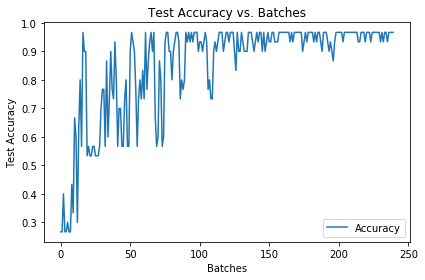

In [8]:
# graph of loss metrics over periods
stats = np.array(stats)
plt.ylabel('Test Accuracy')
plt.xlabel('Batches')
plt.title('Test Accuracy vs. Batches')
plt.tight_layout()
plt.plot(stats, label='Accuracy')
plt.legend()
plt.show()

In [9]:
# confusion matrix
confusion_matrix(y_test, y_test_pred)

array([[ 8,  0,  0],
       [ 0, 13,  1],
       [ 0,  0,  8]])